## JUPITER

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
from astropy.time import Time
from astropy.coordinates import SkyCoord
from collections import defaultdict
import datetime
from utils import *
from astropy.io import ascii

In [3]:
jupiter_table = ascii.read('../data/jupiter_table.dat')

jupiter_ra = jupiter_table['jupiter_ra'].data # ICRS
jupiter_dec = jupiter_table['jupiter_dec'].data

jdates = jupiter_table['start_date'].data # MJD
jdates = [Time(jd, format="mjd").datetime for jd in jdates]

Total stack (over every ScW)

In [4]:
dir = "../data/Jupiter/30-60keV/Images"
scw_dir = '../data/jupiter_table.dat'

jupiter_scws = [str(id).zfill(12) + ".00" + str(ver) for id, ver in zip(jupiter_table['scw_id'].data, jupiter_table['scw_ver'].data)]

s_var = None
s_flu = None
total_max_isgri_exp = 0
body_lim = {}

body_name = 'Jupiter'

for scw in np.sort(os.listdir(dir)):
    if scw.endswith(".fits"):

        try:

            scw_id = scw[:16]
            idx = jupiter_scws.index(scw_id)
            
            f = fits.open(os.path.join(dir, scw))

            if dir == "../data/Jupiter/3-15keV/Images":
                flu = [e for e in f if e.header.get('IMATYPE', None) == "RECONSTRUCTED"][0]
                date_obs = Time(jdates[idx]).datetime
            else:
                flu = [e for e in f if e.header.get('IMATYPE', None) == "INTENSITY"][0]
                date_obs = Time(flu.header['DATE-OBS']).datetime
            sig = [e for e in f if e.header.get('IMATYPE', None) == "SIGNIFICANCE"][0]
            var = [e for e in f if e.header.get('IMATYPE', None) == "VARIANCE"][0]
            # flu = [e for e in f if e.header.get('IMATYPE', None) == "INTENSITY"][0]
            expo = [e for e in f if e.header.get('IMATYPE', None) == "EXPOSURE"][0]

            if sig.data is None or sig.size == 0 or sig.data.sum() == 0:
                print(f"Empty significance image for {scw_id}")
                continue

            wcs = WCS(flu.header)

            j_ra = jupiter_ra[idx]
            j_dec = jupiter_dec[idx]

        except Exception as e:
            print(f"Failed to open {scw}: {e}")
            continue
        
        try:
            body_i, body_j = [
                int(i) for i in 
                wcs.all_world2pix(j_ra, j_dec, 0)
            ]
        except Exception as e:
            print(f"Coordinate transform failed: {e}")
            continue

        plot_span = 20
        detection_span = 20

        # Extract a region around Jupiter's position
        f_data = flu.data[body_i-detection_span:body_i+detection_span, body_j-detection_span:body_j+detection_span]
        v_data = var.data[body_i-detection_span:body_i+detection_span, body_j-detection_span:body_j+detection_span]
        ex_data = expo.data[body_i-detection_span:body_i+detection_span, body_j-detection_span:body_j+detection_span]

        try:
            if s_var is None:
                s_var = v_data.copy()
                s_flu = f_data.copy()
                s_expo = ex_data.copy()
                ref_wcs = wcs.deepcopy()
                ref_j_ra, ref_j_dec = j_ra, j_dec  
                ref_i, ref_j = body_i, body_j      
            else:
                m = ~np.isnan(v_data)
                m &= v_data > 0
                
                s_flu[m] = (f_data[m] / v_data[m] + s_flu[m] / s_var[m]) / (1 / v_data[m] + 1 / s_var[m])
                s_var[m] = 1 / (1 / v_data[m] + 1 / s_var[m])
                s_expo[m] += ex_data[m]
                total_max_isgri_exp += np.nanmax(expo.data)
        except:
            print("Failed to process SCW!")
            continue
            
        body_lim[scw] = dict(
            ic = np.nanmean(v_data**0.5), 
            ic_std = np.nanstd(f_data), 
        )


Plotting

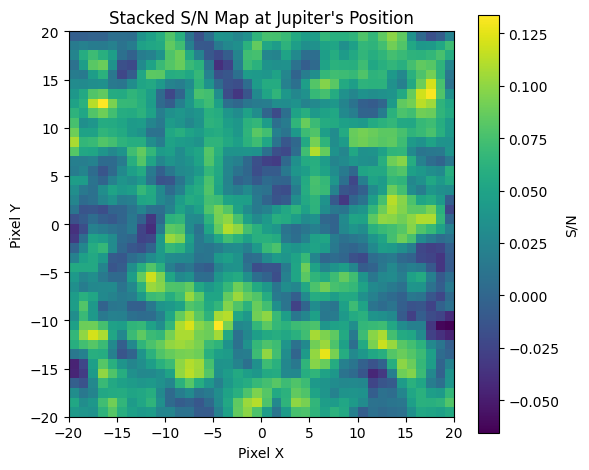

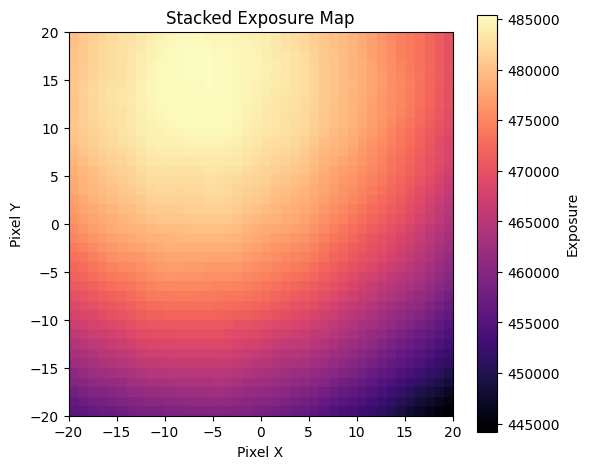

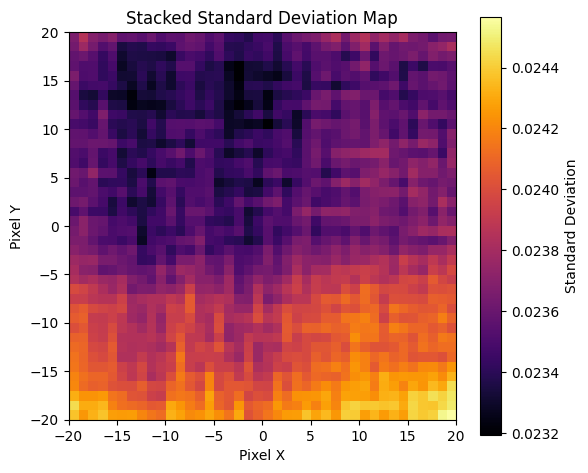

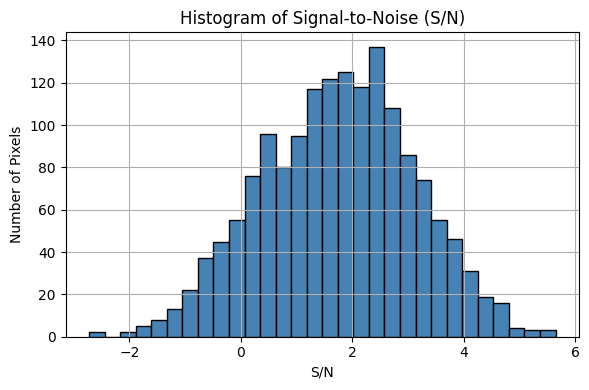

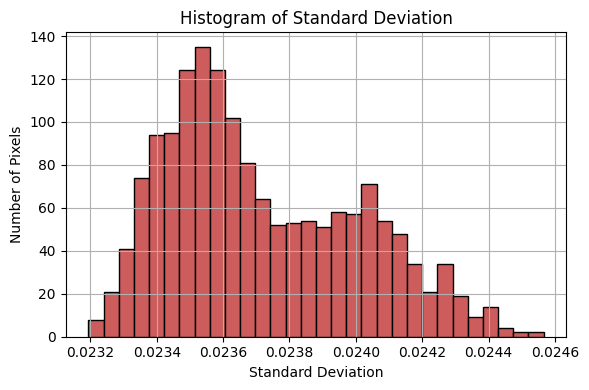

In [ ]:
extent = [-plot_span, plot_span, -plot_span, plot_span]

# 93.6  arcsec/pixel for JEM-X

# Signal-to-noise (S/N) map
plt.figure(figsize=(6, 5))
plt.imshow(s_flu / np.sqrt(s_var), origin='lower', cmap='viridis', extent=extent)
plt.title("Stacked S/N Map at Jupiter's Position")
#plt.scatter(0, 0, c='r', marker='o', s=200, alpha=0.5, label="Jupiter Position")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")
cbar = plt.colorbar()
cbar.set_label("S/N")
plt.tight_layout()

# Effective exposure map (normalized)
plt.figure(figsize=(6, 5))
plt.imshow(s_expo , origin='lower', cmap='magma', extent=extent) # / total_max_isgri_exp
plt.title("Stacked Exposure Map")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")
cbar = plt.colorbar()
cbar.set_label("Exposure")
plt.tight_layout()

# Square root of the variance map
plt.figure(figsize=(6, 5))
plt.imshow(np.sqrt(s_var), origin='lower', cmap='inferno', extent=extent)
plt.title("Stacked Standard Deviation Map")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")
cbar = plt.colorbar()
cbar.set_label("Standard Deviation")
plt.tight_layout()

# Histogram of S/N
plt.figure(figsize=(6, 4))
plt.hist((s_flu / np.sqrt(s_var)).flatten(), bins=30, color='steelblue', edgecolor='black')
plt.title("Histogram of Signal-to-Noise (S/N)")
plt.xlabel("S/N")
plt.ylabel("Number of Pixels")
plt.grid(True)
plt.tight_layout()

# Histogram of √variance
plt.figure(figsize=(6, 4))
plt.hist(np.sqrt(s_var).flatten(), bins=30, color='indianred', edgecolor='black')
plt.title("Histogram of Standard Deviation")
plt.xlabel("Standard Deviation")
plt.ylabel("Number of Pixels")
plt.grid(True)
plt.tight_layout()

S/N at the center of the stacked map: 2.61
Probability of observing S/N >= 2.61: 26.26%


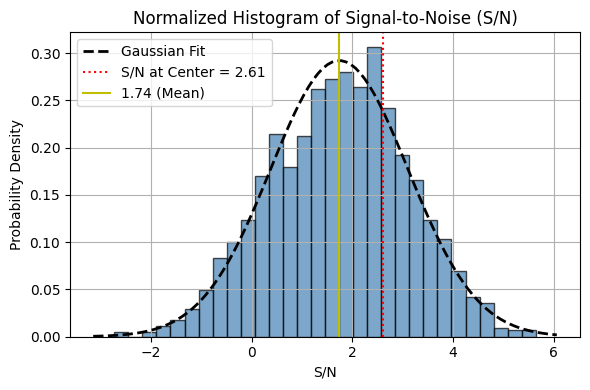

In [5]:
from scipy.stats import norm

# Normalize S/N histogram 
s_n_values = (s_flu / np.sqrt(s_var)).flatten() 
hist, bin_edges = np.histogram(s_n_values, bins=30, density=True) 

bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

mu, std = norm.fit(s_n_values)

# Plot the normalized S/N histogram
plt.figure(figsize=(6, 4))
plt.hist(s_n_values, bins=30, color='steelblue', edgecolor='black', density=True, alpha=0.7)
plt.title("Normalized Histogram of Signal-to-Noise (S/N)")
plt.xlabel("S/N")
plt.ylabel("Probability Density")

# Plot the Gaussian fit
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k--', linewidth=2, label="Gaussian Fit")
plt.legend()
plt.grid(True)
plt.tight_layout()

body_i = np.clip(body_i, plot_span, s_flu.shape[0] - plot_span - 1)
body_j = np.clip(body_j, plot_span, s_flu.shape[1] - plot_span - 1)

center_sn = s_flu[body_i, body_j] / np.sqrt(s_var[body_i, body_j])
#center_sn = s_flu[0, 0] / np.sqrt(s_var[0, 0])
print(f"S/N at the center of the stacked map: {center_sn:.2f}")

plt.axvline(center_sn, color='r', linestyle=':', label=f"S/N at Center = {center_sn:.2f}")
plt.axvline(mu, color='y', linestyle='-', label=f"{mu:.2f} (Mean)")

plt.legend()
plt.tight_layout()

probability = norm.cdf(center_sn, mu, std)
print(f"Probability of observing S/N >= {center_sn:.2f}: {(1 - probability)*100:.2f}%")

In [ ]:
center_flux =[s_flu[body_i, body_j]]
center_var = [s_var[body_i, body_j]]

crabYEAR = [
    2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013,
    2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023
]

crabCR1 = [
    177.78, 187.87, 154.78, 167.87, 178.74, 171.44, 165.48, 166.83, 170.34, 179.76,
    180.38, 177.39, 182.58, 190.21, 176.37, 48.52, 0.00, 0.00, 0.00, 162.07
]

crabERR1 = [
    0.98, 1.13, 0.90, 0.95, 1.96, 1.35, 1.70, 4.00, 3.67, 2.55,
    4.95, 4.88, 4.57, 8.60, 9.31, 6.41, 0.00, 0.00, 0.00, 15.76
]

crabCR2 = []
crabERR2 = []

crabCR3 = [0.1062, np.nan, 0.1117, np.nan, 0.0678, 0.1225, 0.1105, 0.1025, 0.1330, 0.1221, 0.1181, 0.1003, 0.0823, 0.0893, 0.0672, 0.0915, 0.1046, 0.0759, 0.0852, 0.1108]
crabERR3 = [0.0000, np.nan, 0.0000, np.nan, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]


ph_flux, ph_flux_err, erg_flux, erg_flux_err, _ = cr2flux(center_flux, center_var, ['2000-01-01T00:00:00'], [np.nanmean(crabCR3)], [np.nanmean(crabERR3)], [2000])
print(f"Photon flux: {ph_flux[0]:.2e} ± {ph_flux_err[0]:.2e} ph/cm²/s")

Photon flux: -5.90e-05 ± 1.28e-04 ph/cm²/s


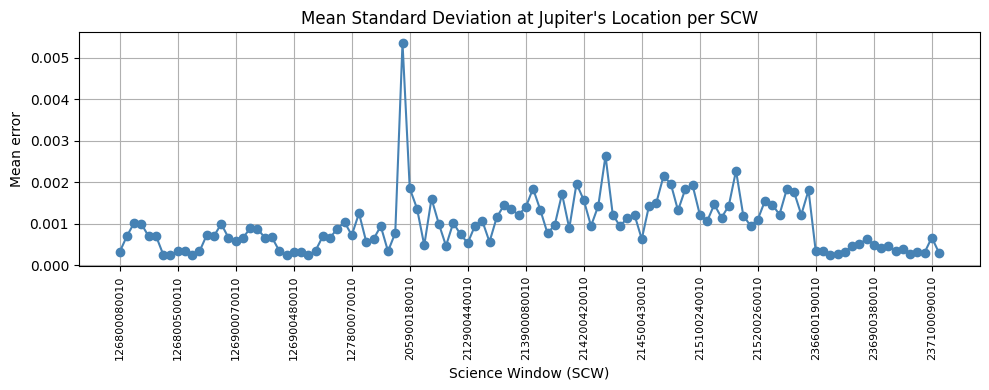

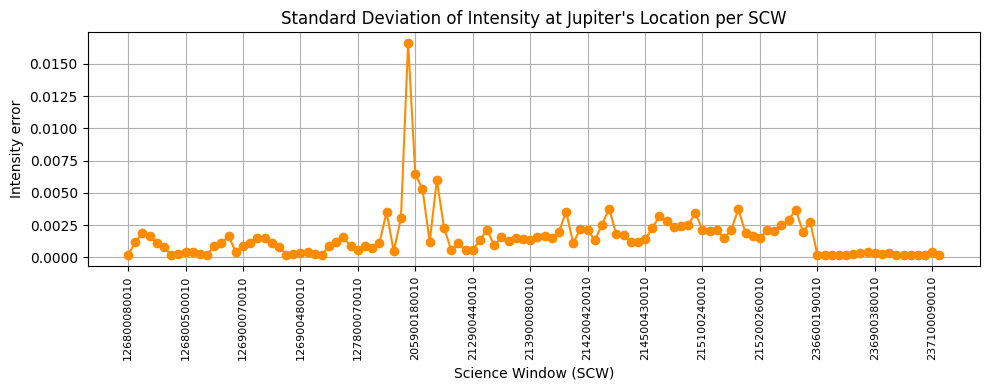

In [12]:
scws = list(body_lim.keys())
mean_std_devs = [body_lim[scw]['ic'] for scw in scws]
intensity_stds = [body_lim[scw]['ic_std'] for scw in scws]

# Plot 1: Mean standard deviation (√variance) per SCW
plt.figure(figsize=(10, 4))
plt.plot(scws, mean_std_devs, marker='o', linestyle='-', color='steelblue')
plt.xticks(rotation=90, fontsize=8, ticks=[i for i in range(len(scws)) if i % 8 == 0], labels=[s[:12] for i,s in enumerate(scws) if i % 8 == 0])
plt.title("Mean Standard Deviation at Jupiter's Location per SCW")
plt.ylabel("Mean error")
plt.xlabel("Science Window (SCW)")
plt.grid(True)
plt.tight_layout()

# Plot 2: Intensity standard deviation per SCW
plt.figure(figsize=(10, 4))
plt.plot(scws, intensity_stds, marker='o', linestyle='-', color='darkorange')
plt.xticks(rotation=90, fontsize=8, ticks=[i for i in range(len(scws)) if i % 8 == 0], labels=[s[:12] for i,s in enumerate(scws) if i % 8 == 0])
plt.title("Standard Deviation of Intensity at Jupiter's Location per SCW")
plt.ylabel("Intensity error")
plt.xlabel("Science Window (SCW)")
plt.grid(True)
plt.tight_layout()

## CRAB

In [21]:
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
from astropy.time import Time
from astropy.coordinates import SkyCoord
from collections import defaultdict
import datetime
from utils import *
from astropy.io import ascii

In [23]:
crab_coords = SkyCoord.from_name("Crab")
crab_ra = crab_coords.ra.deg
crab_dec = crab_coords.dec.deg
print(f"Crab coordinates: RA = {crab_ra}, Dec = {crab_dec}")

Crab coordinates: RA = 83.6324, Dec = 22.0174


In [30]:
'''#dir = "../data/Crab/15-30keV/Images"
dir = "../data/Crab/30-60keV/Images"
#dir = "../data/Crab/3-15keV/Images"

s_var = None
s_flu = None
s_expo = None
total_max_isgri_exp = 0

body_lim = {}

body_name = 'Crab'

for scw in np.sort(os.listdir(dir)):
    if scw.endswith(".fits"):

        try:

            scw_id = scw[:16]
            
            f = fits.open(os.path.join(dir, scw))
            if dir == "../data/Crab/3-15keV/Images":
                flu = [e for e in f if e.header.get('IMATYPE', None) == "RECONSTRUCTED"][0]
            else:
                flu = [e for e in f if e.header.get('IMATYPE', None) == "INTENSITY"][0]
            sig = [e for e in f if e.header.get('IMATYPE', None) == "SIGNIFICANCE"][0]
            var = [e for e in f if e.header.get('IMATYPE', None) == "VARIANCE"][0]
            expo = [e for e in f if e.header.get('IMATYPE', None) == "EXPOSURE"][0]

            wcs = WCS(sig.header)

            try:
                body_i, body_j = [
                    int(i) for i in 
                    wcs.world_to_pixel(SkyCoord(crab_ra, crab_dec, unit="deg"))
                ]
            except Exception as e:
                print(f"Coordinate transform failed: {e}")
                continue

            plot_span = 20
            detection_span = 20

            if False:
                plt.figure(figsize=(4,4))
                plt.imshow(
                    sig.data[body_i-plot_span:body_i+plot_span, body_j-plot_span:body_j+plot_span]
                )

            if False:
                plt.scatter(
                    body_i,
                    body_j,
                    c='r',
                    marker='o',
                    s=200,
                    alpha=0.2
                )
                plt.clim([0, 6])

            f = flu.data[body_i-detection_span:body_i+detection_span, body_j-detection_span:body_j+detection_span]
            v = var.data[body_i-detection_span:body_i+detection_span, body_j-detection_span:body_j+detection_span]
            ex = expo.data[body_i-detection_span:body_i+detection_span, body_j-detection_span:body_j+detection_span]

            # Check if cropped region has the right shape
            if f.shape != (2 * detection_span, 2 * detection_span):
                print(f"Skipping {scw} due to crop shape: {f.shape}")
                continue

            try:
                if s_var is None:
                    s_var = v.copy()
                    s_flu = f.copy()
                    s_expo = ex.copy()
                else:
                    m = ~np.isnan(v)
                    m &= v > 0

                    s_flu[m] = (f[m]/v[m] + s_flu[m]/s_var[m])/(1/v[m] + 1/s_var[m])
                    s_var[m] = 1/(1/v[m] + 1/s_var[m])
                    s_expo[m] += ex[m]
                    total_max_isgri_exp += np.nanmax(expo.data)
            except Exception as e:
                print(f"Failed to process SCW {scw_id}: {e}")
                continue

            body_lim[scw] = dict(
                ic=np.nanmean(np.sqrt(v)), 
                ic_std=np.nanstd(f),
            )
        except Exception as e:
            print(f"Failed to read {scw}: {e}")
            continue'''

'#dir = "../data/Crab/15-30keV/Images"\ndir = "../data/Crab/30-60keV/Images"\n#dir = "../data/Crab/3-15keV/Images"\n\ns_var = None\ns_flu = None\ns_expo = None\ntotal_max_isgri_exp = 0\n\nbody_lim = {}\n\nbody_name = \'Crab\'\n\nfor scw in np.sort(os.listdir(dir)):\n    if scw.endswith(".fits"):\n\n        try:\n\n            scw_id = scw[:16]\n            \n            f = fits.open(os.path.join(dir, scw))\n            if dir == "../data/Crab/3-15keV/Images":\n                flu = [e for e in f if e.header.get(\'IMATYPE\', None) == "RECONSTRUCTED"][0]\n            else:\n                flu = [e for e in f if e.header.get(\'IMATYPE\', None) == "INTENSITY"][0]\n            sig = [e for e in f if e.header.get(\'IMATYPE\', None) == "SIGNIFICANCE"][0]\n            var = [e for e in f if e.header.get(\'IMATYPE\', None) == "VARIANCE"][0]\n            expo = [e for e in f if e.header.get(\'IMATYPE\', None) == "EXPOSURE"][0]\n\n            wcs = WCS(sig.header)\n\n            try:\n         

In [56]:
from scipy.ndimage import shift

dir = "../data/Crab/30-60keV/Images"

s_var = None
s_flu = None
s_expo = None
total_max_isgri_exp = 0

body_lim = {}
body_name = 'Crab'

for scw in np.sort(os.listdir(dir)):
    if scw.endswith(".fits"):
        try:
            scw_id = scw[:16]
            f = fits.open(os.path.join(dir, scw))

            if dir == "../data/Crab/3-15keV/Images":
                flu = [e for e in f if e.header.get('IMATYPE', None) == "RECONSTRUCTED"][0]
            else:
                flu = [e for e in f if e.header.get('IMATYPE', None) == "INTENSITY"][0]
            sig = [e for e in f if e.header.get('IMATYPE', None) == "SIGNIFICANCE"][0]
            var = [e for e in f if e.header.get('IMATYPE', None) == "VARIANCE"][0]
            expo = [e for e in f if e.header.get('IMATYPE', None) == "EXPOSURE"][0]

            wcs = WCS(sig.header)
            try:
                center_i, center_j = wcs.world_to_pixel(SkyCoord(crab_ra, crab_dec, unit="deg"))
            except Exception as e:
                print(f"Coordinate transform failed: {e}")
                continue

            detection_span = 20
            di, dj = int(center_i), int(center_j)
            frac_shift_i = center_i - di
            frac_shift_j = center_j - dj

            f_patch = flu.data[di-detection_span:di+detection_span, dj-detection_span:dj+detection_span]
            v_patch = var.data[di-detection_span:di+detection_span, dj-detection_span:dj+detection_span]
            ex_patch = expo.data[di-detection_span:di+detection_span, dj-detection_span:dj+detection_span]

            if f_patch.shape != (2 * detection_span, 2 * detection_span):
                print(f"Skipping {scw} due to crop shape: {f_patch.shape}")
                continue

            # Apply sub-pixel shifts
            f_patch = shift(f_patch, shift=(-frac_shift_i, -frac_shift_j), order=1, mode='nearest')
            v_patch = shift(v_patch, shift=(-frac_shift_i, -frac_shift_j), order=1, mode='nearest')
            ex_patch = shift(ex_patch, shift=(-frac_shift_i, -frac_shift_j), order=1, mode='nearest')

            if s_var is None:
                s_var = v_patch.copy()
                s_flu = f_patch.copy()
                s_expo = ex_patch.copy()
            else:
                m = ~np.isnan(v_patch)
                m &= v_patch > 0

                s_flu[m] = (f_patch[m]/v_patch[m] + s_flu[m]/s_var[m]) / (1/v_patch[m] + 1/s_var[m])
                s_var[m] = 1 / (1/v_patch[m] + 1/s_var[m])
                s_expo[m] += ex_patch[m]
                total_max_isgri_exp += np.nanmax(expo.data)

            body_lim[scw] = dict(
                ic=np.nanmean(np.sqrt(v_patch)), 
                ic_std=np.nanstd(f_patch),
            )

        except Exception as e:
            print(f"Failed to process {scw_id}: {e}")
            continue


In [57]:
from scipy.ndimage import center_of_mass
sn_map = s_flu / np.sqrt(s_var)
com = center_of_mass(sn_map)
print(f"Centroid offset from center: {(com[0] - detection_span):.2f}, {(com[1] - detection_span):.2f}")


Centroid offset from center: 1.31, -1.48


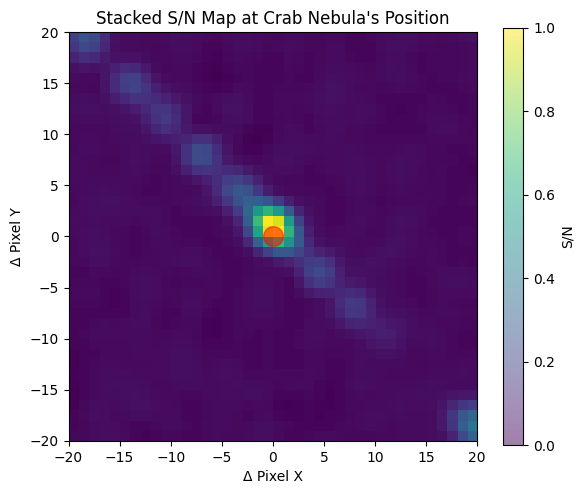

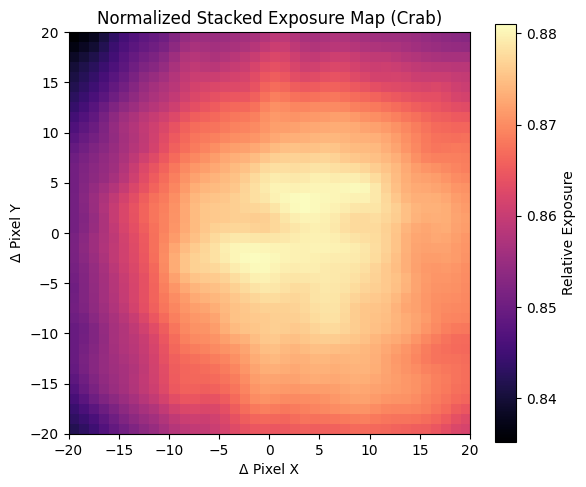

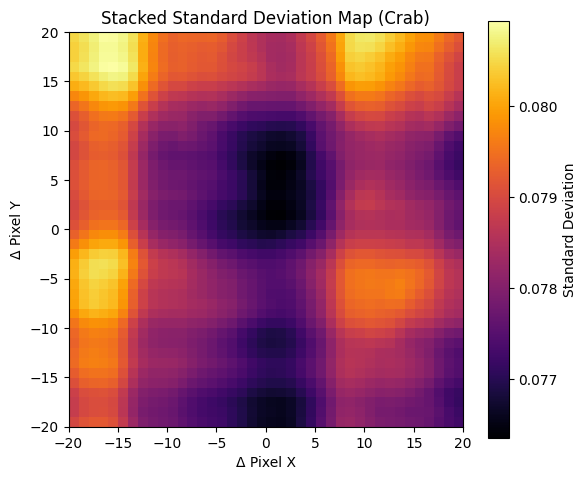

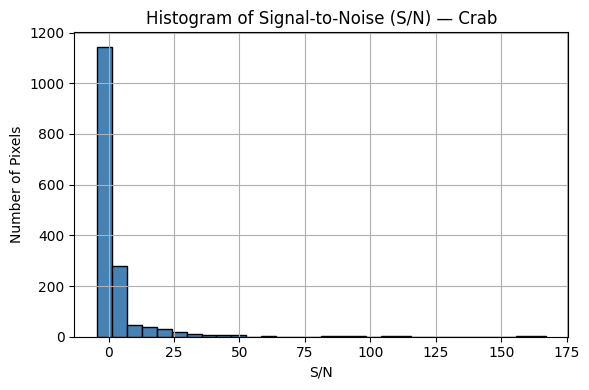

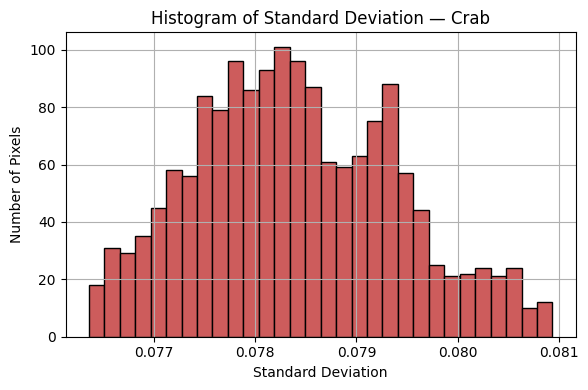

In [58]:
extent = [-detection_span, detection_span, -detection_span, detection_span]

# Signal-to-noise (S/N) map
plt.figure(figsize=(6, 5))
plt.imshow(s_flu / np.sqrt(s_var), origin='lower', cmap='viridis', extent=extent)
plt.scatter(0, 0, c='r', marker='o', s=200, alpha=0.5, label="Crab Position")
plt.title("Stacked S/N Map at Crab Nebula's Position")
plt.xlabel("Δ Pixel X")
plt.ylabel("Δ Pixel Y")
cbar = plt.colorbar()
cbar.set_label("S/N")
plt.tight_layout()

# Effective exposure map (normalized)
plt.figure(figsize=(6, 5))
plt.imshow(s_expo / total_max_isgri_exp, origin='lower', cmap='magma', extent=extent)
plt.title("Normalized Stacked Exposure Map (Crab)")
plt.xlabel("Δ Pixel X")
plt.ylabel("Δ Pixel Y")
cbar = plt.colorbar()
cbar.set_label("Relative Exposure")
plt.tight_layout()

# Square root of the variance map
plt.figure(figsize=(6, 5))
plt.imshow(np.sqrt(s_var), origin='lower', cmap='inferno', extent=extent)
plt.title("Stacked Standard Deviation Map (Crab)")
plt.xlabel("Δ Pixel X")
plt.ylabel("Δ Pixel Y")
cbar = plt.colorbar()
cbar.set_label("Standard Deviation")
plt.tight_layout()

# Histogram of S/N
plt.figure(figsize=(6, 4))
plt.hist((s_flu / np.sqrt(s_var)).flatten(), bins=30, color='steelblue', edgecolor='black')
plt.title("Histogram of Signal-to-Noise (S/N) — Crab")
plt.xlabel("S/N")
plt.ylabel("Number of Pixels")
plt.grid(True)
plt.tight_layout()

# Histogram of √variance
plt.figure(figsize=(6, 4))
plt.hist(np.sqrt(s_var).flatten(), bins=30, color='indianred', edgecolor='black')
plt.title("Histogram of Standard Deviation — Crab")
plt.xlabel("Standard Deviation")
plt.ylabel("Number of Pixels")
plt.grid(True)
plt.tight_layout()


S/N at the center of the stacked map: 40.99
Probability of observing S/N >= 40.99: 0.33%


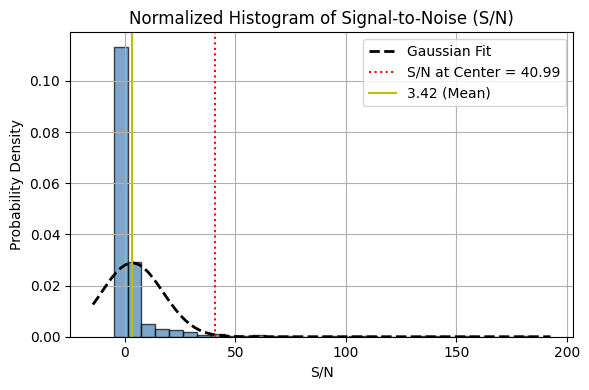

In [55]:
from scipy.stats import norm

# Normalize S/N histogram 
s_n_values = (s_flu / np.sqrt(s_var)).flatten() 
hist, bin_edges = np.histogram(s_n_values, bins=30, density=True) 

bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

mu, std = norm.fit(s_n_values)

# Plot the normalized S/N histogram
plt.figure(figsize=(6, 4))
plt.hist(s_n_values, bins=30, color='steelblue', edgecolor='black', density=True, alpha=0.7)
plt.title("Normalized Histogram of Signal-to-Noise (S/N)")
plt.xlabel("S/N")
plt.ylabel("Probability Density")

# Plot the Gaussian fit
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k--', linewidth=2, label="Gaussian Fit")
plt.legend()
plt.grid(True)
plt.tight_layout()

body_i = np.clip(body_i, plot_span, s_flu.shape[0] - plot_span - 1)
body_j = np.clip(body_j, plot_span, s_flu.shape[1] - plot_span - 1)

center_sn = s_flu[body_i, body_j] / np.sqrt(s_var[body_i, body_j])
#center_sn = s_flu[0, 0] / np.sqrt(s_var[0, 0])
print(f"S/N at the center of the stacked map: {center_sn:.2f}")

plt.axvline(center_sn, color='r', linestyle=':', label=f"S/N at Center = {center_sn:.2f}")
plt.axvline(mu, color='y', linestyle='-', label=f"{mu:.2f} (Mean)")

plt.legend()
plt.tight_layout()

probability = norm.cdf(center_sn, mu, std)
print(f"Probability of observing S/N >= {center_sn:.2f}: {(1 - probability)*100:.2f}%")